# TES Analysis

This software was created for a bachelor project by Callum Blair in 2019. 
Please contact me at callumblair@hotmail.co.uk if anything breaks. 
Further information can be found in my thesis, which describes how some of the functions work, found at (https://github.com/cgfb94/sensor-analysis)

This notebook will walk through some of the basic functionality of the classes that have been created to automate the analysis of Transition Edge Sensors. The program consists mainly of 3 parts:

- IV_curve
- IV_series
- read_qdp

# IV_curve

This deals with the analysis of a single set of measurements: calculating TES current/voltage and reading the power. The experimental parameters of the physical setup need to be input:

- R_fb 
- M_ratio
- R_shunt

Additionally, the parasitic voltage R_stray also needs to be input for the current build. Methods to determine this exist in the older versions of the IV_curve class, but are not currently used. 

Tweaks are used to alter the data by a factor. Default to 1

The method of determining the y_offset is currently only suitable for double sided curves. Single sided data would need an alternative method for determining the offset.

# IV_series

Encompasses a series of measurements taken on one device. Accepts a directory as input then parses the data, creates a series of IV_curve objects, which then return the power readout for each dataset. These power readouts are then used to fit the power model and return the device paramters (thermal conductance, n, critical temperature)

# read_qdp

Reads an ascii-qdp data file. Returns a pandas dataframe with the current, voltage and power readings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d

import read_qdp
import os
import sys


import time

In [5]:
class IV_curve(object):
    '''
    
    Methods:
    self.plotPV() - plots PV graph
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    self.plotRegions(raw=1) - set raw to false to plot analysed IV regions
    
    #TODO - Store the temperatures in the object
    '''
    
    def __init__(self, rawIV, params = 0, name='NA', tweaks = [1,1,1]): 
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two coloums of the dataframe and saves 
        them as attributes. Dataframe can consist of more coloums but they are ignored. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be inlcuded as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attriutes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - whether the data shows signs of superconductivity
        y_offset (float) 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- experimental parameters
        gain (float) - calcuated from M_ratio and R_fb
        R_stray (float) - either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range
        '''
        self.df = rawIV
        # Drop NaNs in spreadsheet to prevent errors later 
        rawI = (rawIV.iloc[:,0].dropna()).values #Store as individual np.arrays for more readable code
        self.rawI = [entry * tweaks[0] for entry in rawI]
        rawV = (rawIV.iloc[:,1].dropna()).values
        self.rawV = [entry * tweaks[1] for entry in rawV]
        try:
            self.T_BB = rawIV.iloc[:,4].dropna().values
            self.T_bath = rawIV.iloc[:,3].dropna().values
        except: 
            print("No supplied Temperature data")
            
        self.P = False
        try:
            assert len(rawIV.columns) > 5
            self.P_BB = (rawIV.iloc[:,-1]).dropna()
            for entry in self.P_BB:
                if entry != 0:
                    self.P = True
        except:
            print("Failed to parse Power Data")
            
        self.raw_grad = np.gradient(self.rawV, self.rawI)#Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend
        
        #iniditalise these values with the methods
        self.name = name
        self.y_offset = 0
        
        # All needed to calculate adjusted I and V etc. If params are included in initialisation, then they are
        # used. Otherwise defualts are used.
        # TODO: raise exception if len is not 3
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except IndexError:
                print("Error: Parameters not correct")
                return
        else:
            print("WARNING: Using defualt paramters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
        
        
    ############################calc_methods############################   
        
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_tes (array) data from tweak(float), y_offset (float), gain (float).
        tweaks not yet used
        '''
        
        self.I_TES = [(entry - self.y_offset) * (10**6) * self.gain for entry in self.rawV]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generates V_bias data
        '''
        self.V_bias = [((self.rawI[i]) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        self.P_TES = [self.I_TES[index] * self.V_bias[index] for index in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Test if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if abs(min(grad)) > 2*(grad_av) and min(grad) < 0:
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    ############################utility methods############################   
    
    def f(self, x, A, B):
        ''' 
        Function of straight line for optimisation function to find
        coefficients for.
        '''
        return A*x + B
        
    def fit_ohmic(self, inputdataX, inputdataY):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        r1start, r1end = (0,7)
        r2start, r2end = (-7,-1)
        
        firstx = min(inputdataX)
        lastx = max(inputdataX)
        xvals = np.linspace(firstx, lastx)

        #Slice the data in the frame and store in an array 
        yvals1 = inputdataY[r1start:r1end]
        yvals2 = inputdataY[r2start:r2end]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = inputdataX[r1start:r1end]
        xvals2 = inputdataX[r2start:r2end]
        lineDataX = np.append(xvals1, xvals2)

        #fit the sliced data to a line
        C, D = curve_fit(self.f, lineDataX, lineDataY)[0]

        return C , D , xvals
    
    def power_readout(self, plot = 0):
        indices = []
        count = 0 
        for index in range(len(self.raw_grad)):
            if self.raw_grad[index] < 0:
                count += 1
            else:
                count = 0
            if count >= 3:
                indices.append(index-count)
                break
                    
        count = 0
        for index in range(len(self.raw_grad)):
            if self.raw_grad[-index] < 0:
                count += 1
            else:
                count = 0
            if count >= 3:
                indices.append(-(index-count))
                break
        readout = 0  
        if plot:
            if len(indices) == 2:
                readout = (self.P_TES[indices[0]] +  self.P_TES[indices[1]])/2
            elif len(indices) == 1:
                readout = self.P_TES[indices[0]]
            else:
                readout = 0
        
        self.readout_idx = indices
        self.readout = readout
        return readout
    
    ###############Plotting Methods###################
    def plotRaw(self):
        plt.scatter(self.rawI, self.rawV, label='Raw IV')
        plt.grid()
        plt.title(self.name)
        plt.xlabel('Current Bias (mA)')
        plt.ylabel('Feedback Voltage (V)')
        plt.show()
        
    def plotIV(self, plot = True):
        '''
        Plots the calibrated IV curve if plot is set to true in the args. Otherwise just calcs R_nn
        '''
        C, D , Axvals = self.fit_ohmic(self.V_bias, self.I_TES)
        self.rnn = 1/C
        if plot:
            fig, ax = plt.subplots()
            #plt.figure(figsize=(50,50))
            plt.plot(Axvals, self.f(Axvals, C , D), color='r', label='Load Line')
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV')
            if len(self.readout_idx) == 2:
                plt.scatter([self.V_bias[self.readout_idx[0]], self.V_bias[self.readout_idx[1]]], [self.I_TES[self.readout_idx[0]], self.I_TES[self.readout_idx[1]]])
            ax.set_xlabel("Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            plt.show()
            
    def plotPR(self, name = ''):
        fig, ax = plt.subplots()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES PR')#, alpha=0.2)
        plt.title("Power vs Resistance Curve: Index - " + str(name))
        ax.set_xlabel("TES Resistance (ohm)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.axvline(self.rnn, color='r',label='Rnn: ' + str(round(self.rnn,5)))
        plt.legend()
    
    def plotPV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV')
        plt.title("Power Curve")
        ax.set_xlabel("Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        
        
        
    ###############Methods TODO###################
    def smooth_IV(): #Remove qunatum jumps?
        #TODO
        ''' Maybe a function to smooth noisy data before we find the 
        y offset. 
        Inputs: rawIV (or just use self?)
        Outputs: stores smoothRawIV in self
        '''
        pass
    
    def reject_outliers(self, data, m = 2.):
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def y_search(self, step, pivot, precision):

        ys = []
        counts = []
        
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        
        for y_off in np.arange(pivot-(10*step),pivot+(step*10),step/10):
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[index] * V_bias[index] for index in range(len(self.I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            count =0
            max_R = max(R_TES)
            
            #for entry in P_grad_smooth:
                #count += abs(entry)**2
            for i in range(int(len(R_TES)/10)-1):
                count += np.sqrt((R_TES[i] - R_TES[-i])**2)
                count += (R_TES[i] - self.rnn)**2
                count += (R_TES[-i] - self.rnn)**2
                
            count += len(R_TES)*(self.rnn - max(R_TES))**2
            
            for entry in P_TES:
                if entry < 0:
                    count += 10* entry **2
            
            for entry in R_TES:
                if entry < 0:
                    count += 10* entry**2
            
                
            counts.append(count)
            ys.append(y_off)

        y_offset = ys[np.argmin(counts)]
        

        return self.y_search(step/10, y_offset, precision)
    
    def y_search_nonsuper(self, step, pivot, precision):

        ys = []
        counts = []
        
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        
        for y_off in np.arange(pivot-(10*step),pivot+(step*10),step/10):
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[index] * V_bias[index] for index in range(len(self.I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            count =0
            max_R = max(R_TES)
            
            #for entry in P_grad_smooth:
                #count += abs(entry)**2
            for i in range(int(len(R_TES)/10)-1):
                count += np.sqrt((R_TES[i] - R_TES[-i])**2)
                count += (R_TES[i] - self.rnn)**2
                count += (R_TES[-i] - self.rnn)**2
                
            count += len(R_TES)*(self.rnn - max(R_TES))**2
            
            for entry in P_TES:
                if entry < 0:
                    count += 10* (entry **2)
            
            for entry in R_TES:
                if entry < 0:
                    count += 10* (entry**2)
            
                
            counts.append(count)
            ys.append(y_off)

        y_offset = ys[np.argmin(counts)]
        

        return self.y_search(step/10, y_offset, precision)
        
    def reverse_y_offset(self):
        '''Requires R_stray to have been already calculated or input.
        Attempts to calc offset through optimising the power plot. 
        '''
        if self.superconducting:
            self.y_search(5,0,0.000001)
        else:
            self.y_search_nonsuper(5,0,0.000001)
        
    def calc_all(self):
        self.power_readout()
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.reverse_y_offset()
        
        self.calc_I_TES()
        self.calc_V_bias()
        self.plotIV(False)
        self.calc_P_TES()
        self.calc_R_TES()
        self.power_readout(True)

In [22]:
class IV_series(object):
    
    def __init__(self, input_string,  params, tweaks = [1,1,1], mode = 'dir'):
        self.R_nn = 0
        self.R_stray = 0 
        
        self.name = input_string
        
        if mode == 'dir':
            self.read_dir(input_string)
        elif mode == 'files':
            self.read_files(input_string)
        elif mode == 'excel':
            self.read_excel(input_string)
            tweaks = [1,1,1]
        else:
            print("Please select mode: dir/files/excel")
            return
        
        
        self.data = [IV_curve(series, params, filename, tweaks) for series, filename in self.series]
        

    def set_R_stray(self, val):
        self.R_stray = val
        
    def set_rnn(self, val):
        self.R_nn = val
        
    def calc_R_stray(self):
        pass # TODO impliment 
        
        
    def calc_R_nn(self):
        average = 0
        for IV_curve in self.data:
            IV_curve.plotIV(False)
            average += IV_curve.rnn
        
        IV_series.R_nn = average/len(self.data)
    
    
    def read_dir(self, dirname):
        series = []
        for filename in os.listdir(dirname):
            if filename.endswith(".qdp"):
                #print(filename)
                series.append((read_qdp.read_qdp(dirname+ '\\' +filename), filename))
                
        self.series = series    
        
    def read_files(self, filenames):
        series = []
        for filename in filenames:
            if filename.endswith(".qdp"):
                series.append((read_qdp.read_qdp(filename), filename))
        self.series = series     
        
    def read_excel(self, filename):
        dataDict = pd.read_excel(filename, sheet_name=None)
        series = []
        for name, sheet in dataDict.items():
            new1 = sheet.iloc[:,0]
            new2 = sheet.iloc[:,1]
            new3 = sheet.iloc[:,2]
            try:
                new4 = sheet[['T bath', 'T BB', 'P BB']].copy()
                series.append((pd.concat([new1,new2,new3,new4], axis=1), name))
            except:
                print("Cannot find T BB and T bath or PBB: Please rename in sheet")
                series.append((pd.concat([new1,new2], axis=1), name))            
        
        self.series = series
        
    def plot_power(self, plot=True):
        #powers_off = []
        powers = []
        t_bath = []
        #t_bath_on = []
        
        for entry in self.data:
            if entry.superconducting and not entry.P and entry.valid:
                powers.append(entry.power_readout(True))
                t_bath.append(np.average(entry.T_bath))
                
            #elif entry.superconducting and entry.P:
             #   powers_on.append(entry.power_readout(True))
              #  t_bath_on.append(np.average(entry.T_bath))
            
        self.t_bath = t_bath
        #self.t_bath_off = t_bath_off
        self.powers = powers
        #self.powers_on = powers_on
        
        if plot:
            plt.figure(figsize=(10,5))
            plt.scatter(t_bath, powers)
            plt.axis([0,max(t_bath)*1.2,0,max(powers)*1.2])
            plt.xlabel('T bath (mK)')
            plt.ylabel('P Joule (pW)')
            plt.grid()
            plt.show()
        
    
    
    def fit_power(self, plot=True, save=False, xtweak=0.001, ytweak=1):
        def f2(x, K, T_c, n):
                return K*(T_c**n - x**n)
            
        xdata = [entry*xtweak for entry in self.t_bath]
        ydata = [entry*ytweak for entry in self.powers]

        
        popt, pcov = curve_fit(f2, xdata, ydata,maxfev=1000000)#, p0=(0,0,0))
        self.G = popt[0] * (popt[1]**(popt[2]-1)) * popt[2]
        if plot:
            nxdata = np.arange(0, max(xdata)*1.2, 0.0001)
            plt.figure(figsize=(10,5))
            plt.scatter(xdata, ydata)
            plt.plot(nxdata, f2(nxdata, *popt), 'r-')
            plt.axis([0,max(xdata)*1.2,0,max(ydata)*1.2])
            plt.grid()
            plt.xlabel('T bath (K)')
            plt.ylabel('P Joule (fW)')
            plt.figtext(.7, .8, "K: " + '{:.4e}'.format(popt[0]) + " $\\frac{fW}{K^n}$", backgroundcolor='w' )
            plt.figtext(.7, .75, "n: " + str(round(popt[2],4)), backgroundcolor='w')
            plt.figtext(.7, .7, "$T_c$: " + str(round(popt[1],4)) + ' K' , backgroundcolor='w')
            plt.figtext(.7, .65, "G: " + '{:.4e}'.format(self.G) + ' fW/K', backgroundcolor='w')
            if save:
                plt.savefig(str(self.name) + '.png')
            plt.show()

        return popt
    
    def valid_entries(self):
        with open(str(self.name) + "_errors.txt", "a") as text_file:
            for idx in range(len(self.data)):
                if np.average(self.data[idx].P_TES) < 0 or self.data[idx].readout <= 0:
                    self.data[idx].valid = False
                    print(f"entry: {idx} is not valid| file: {self.data[idx].name}|  super: {self.data[idx].superconducting} | readout: {self.data[idx].readout} | powerAv: {np.average(self.data[idx].P_TES)}"   , file=text_file)
                else:
                    self.data[idx].valid = True

    
    def analyse_IV(self, R_stray,  xtweak=0.001, ytweak=1, debug=False):
        for entry in self.data:
            entry.R_stray = R_stray
            entry.calc_all()
            
        self.valid_entries()
            
        self.plot_power(plot=True)
        params = self.fit_power(save=True,xtweak=xtweak, ytweak=ytweak)
        
        with open(str(self.name) + ".txt", "w") as text_file:
            print(f"K: {params[0]} | n: {params[2]} | Tc: {params[1]} | G: {self.G}", file=text_file)
            
        if debug:
            for entry in self.data:
                entry.plotRaw()
                entry.plotIV()
                entry.plotPV()
                entry.plotPR()
        
        

# Examples

Below we see some example series objects being initialised. The first entry is the directory or filename, the mode can be set to 'dir' or 'excel' to read data from different formats (default=dir). The paramters are then passed as a list to the IV_series, followed by any tweaks to the values that are required.
Warning printouts are generated if some data could not be found in the files. 

In [23]:
s = IV_series('2014-06-19', [30002.9, 18.9333333333333, 0.001278], [1,10.6869,1], mode = 'dir')
se = IV_series('17D_usb_low.xls', [30002.9, 18.9333333333333, 0.001278], [1,10.6869,1], mode = 'excel')
st = IV_series('test', [100002.9, 3.18541, 0.004567])

Cannot find T BB and T bath or PBB: Please rename in sheet
No supplied Temperature data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data
Failed to parse Power Data


# Using am IV_series object

Once the object has been initialised, the analyse_IV method can be called. The first input is the R_stray for the measurements, the second and third allow for tweaking to the values such that the axes are correct. Care should be taken to ensure that the tweaks result in the correct order of magnitude, as this will affect the returned values. 

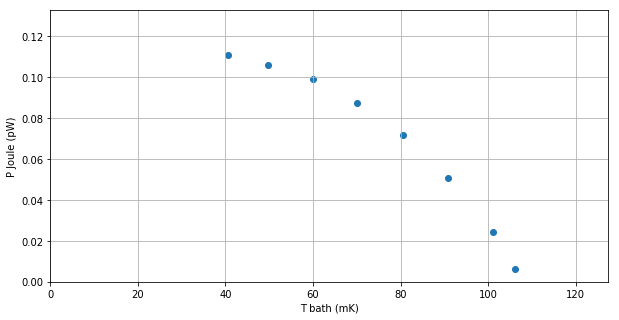

C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in power


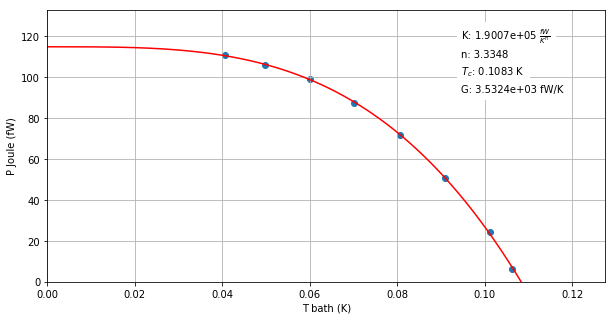

In [24]:
se.analyse_IV(0.0016,0.001,1000)

C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


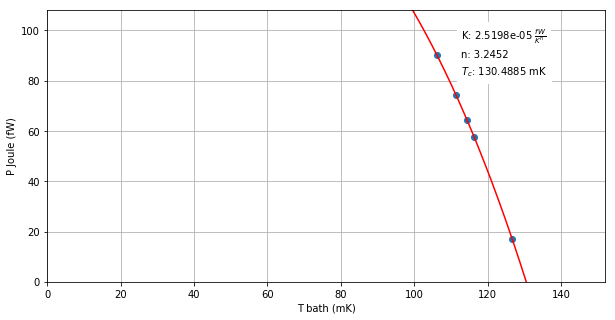

In [71]:
s.analyse_IV(0.1516,1,1000)

C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


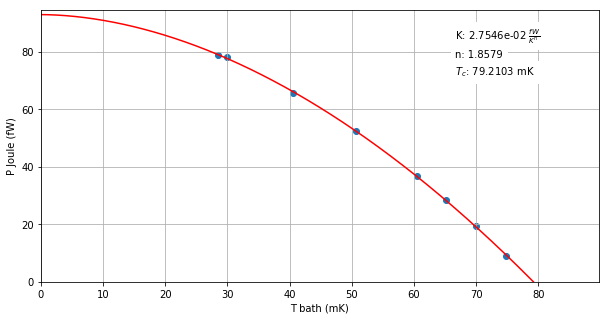

In [75]:
st.analyse_IV(0.00239,1,10000)

In [8]:
for entry in se.data:
    #for i in range(10):
        #entry.R_stray = i/1000
    entry.R_stray = 0.0016
    entry.calc_all()

# Accessing individual IV_curves

The entries in the series can be accessed and the data can be plotted individually. The loop below plots the raw, IV and PR curves for all of the measurements in the series. This can be useful to check for outliers and to ensure eveything is working as expected. 

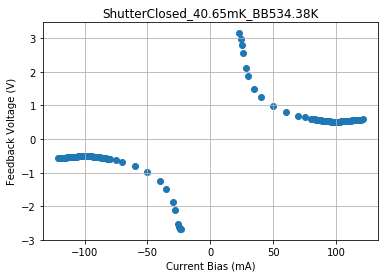

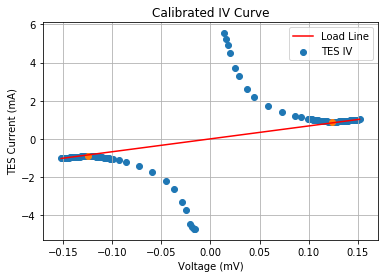

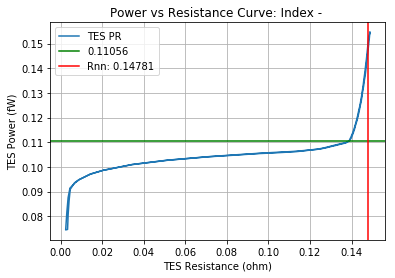

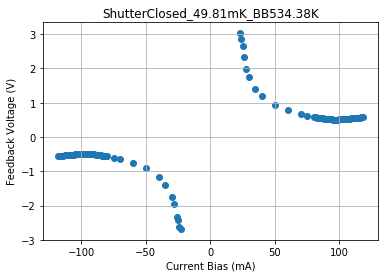

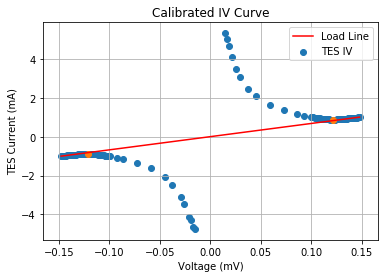

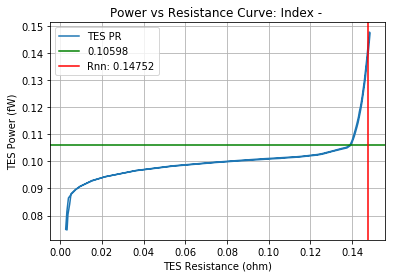

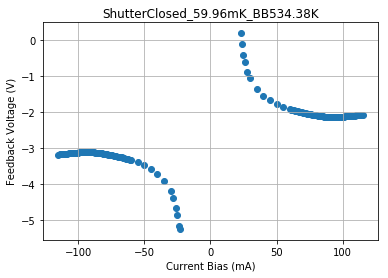

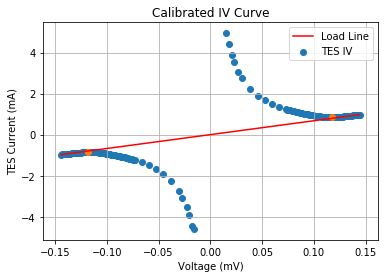

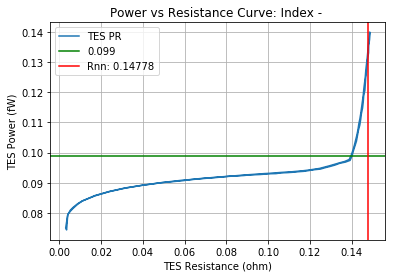

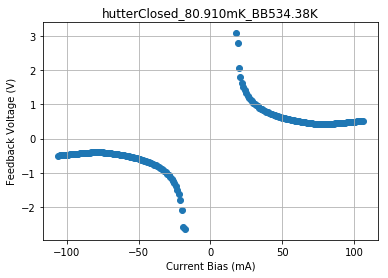

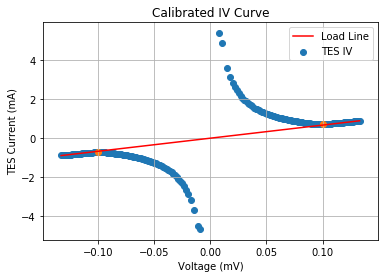

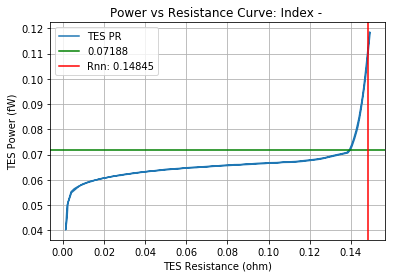

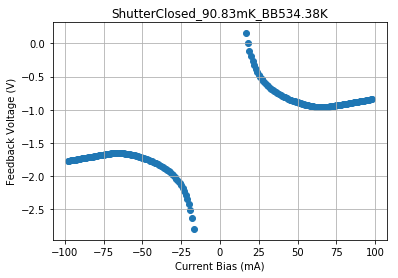

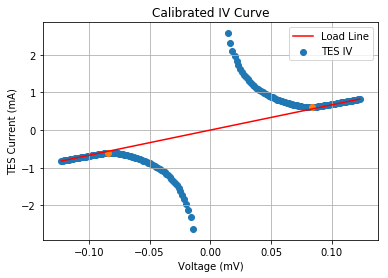

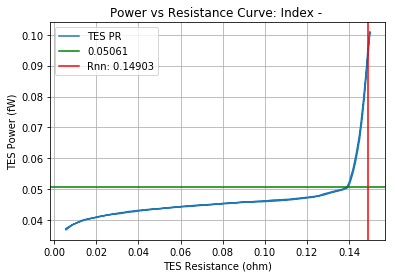

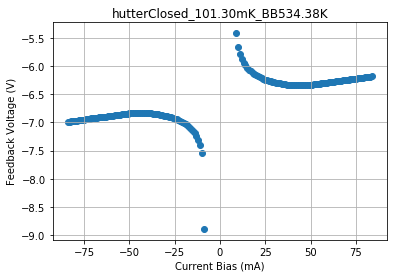

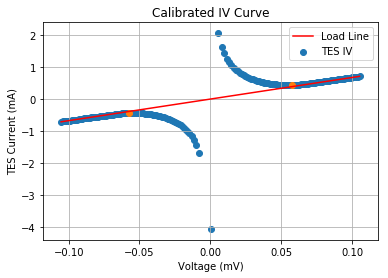

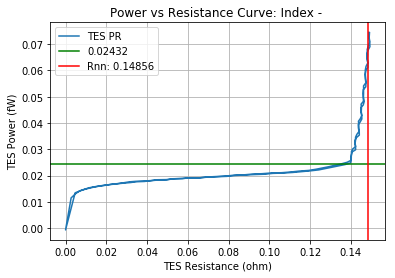

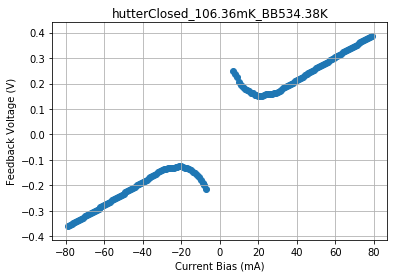

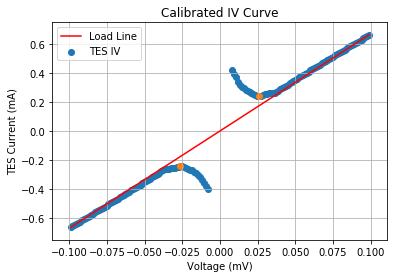

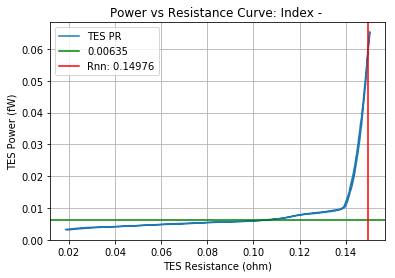

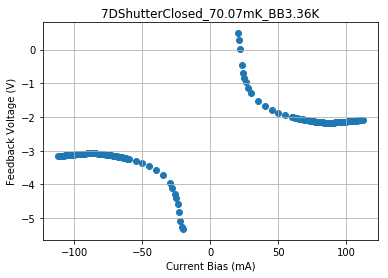

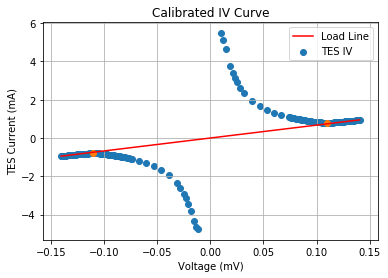

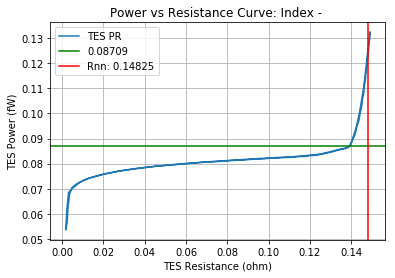

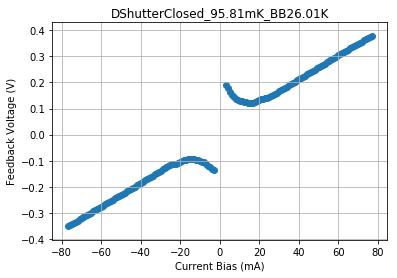

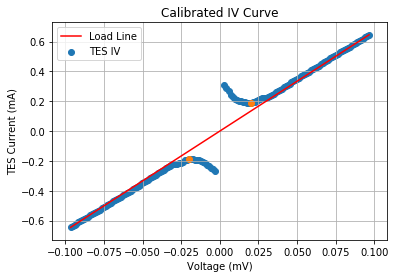

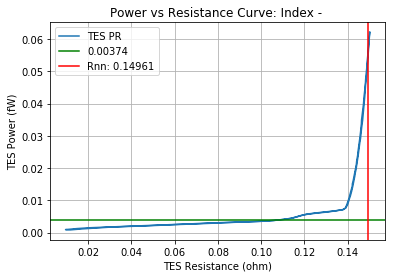

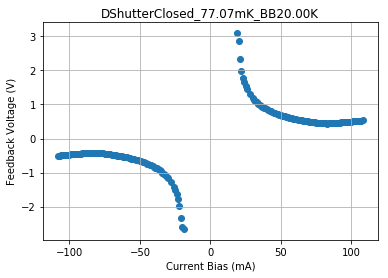

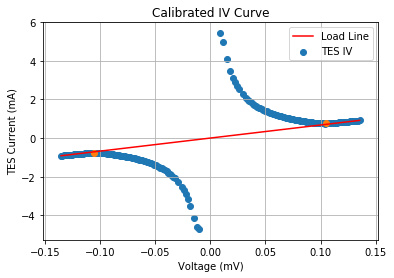

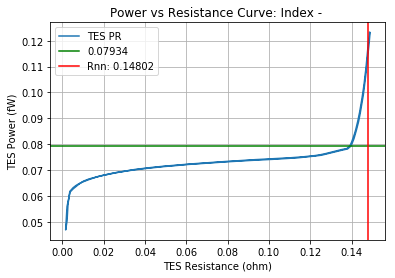

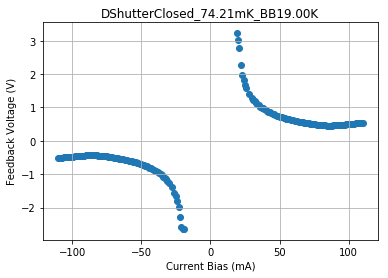

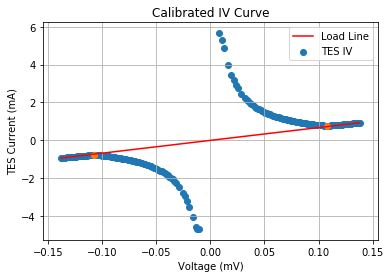

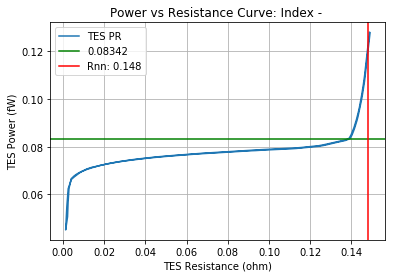

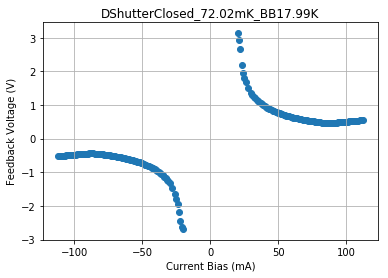

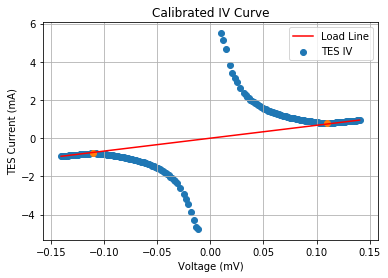

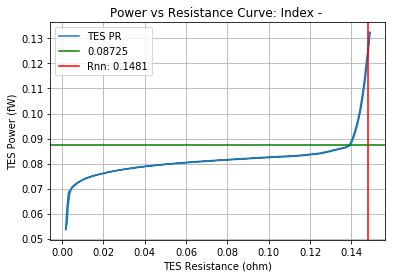

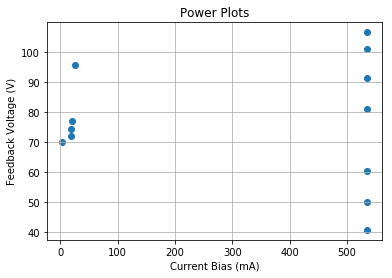

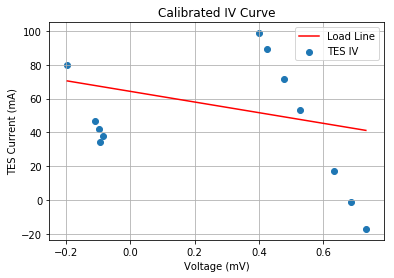

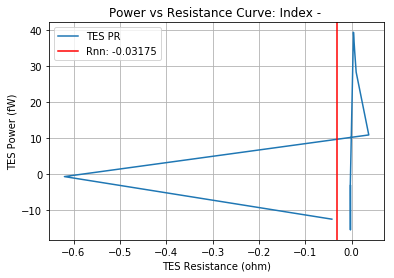

In [9]:
for entry in se.data:
    entry.plotRaw()
    entry.plotIV()
    entry.plotPR()
    plt.show()

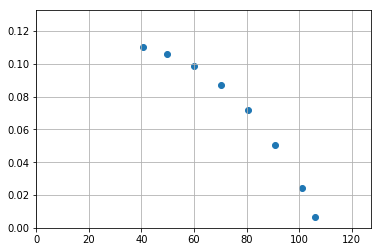

In [31]:
se.plot_power()

C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars


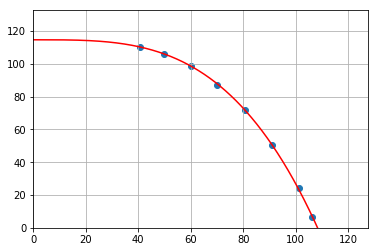

array([1.88176972e-05, 1.08302663e+02, 3.33478043e+00])

In [32]:
se.fit_power()

# Outliers in Readings

The presence of measurements that are exposed to incident radiation, or other outliers may make fitting the power law difficult. Remove these values for better fitting values. 

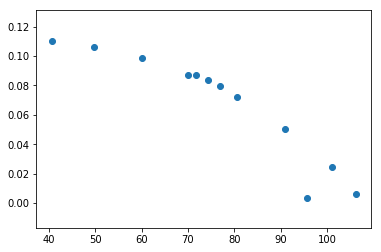

In [215]:
plt.scatter(se.t_bath, se.powers)

Individual entries can be verified like as below

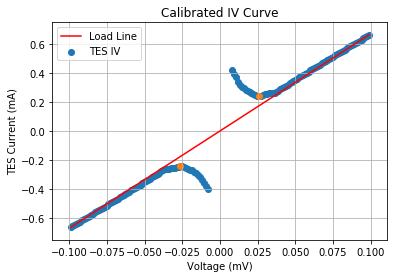

True


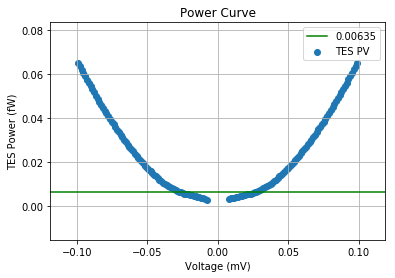

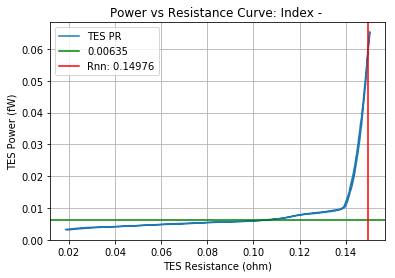

In [199]:
se.data[6].plotIV()
se.data[6].plotPV()
se.data[6].plotPR()
print(se.data[6].superconducting)

In [52]:
for entry in s.data:
    #for i in range(10):
        #entry.R_stray = i/1000
    entry.R_stray = 0.1516
    entry.calc_all()

C:\Users\callu\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


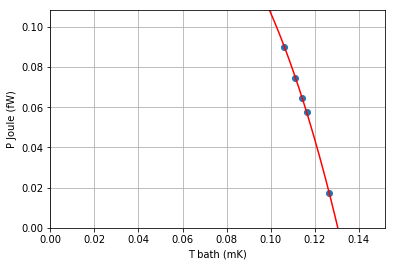

In [92]:
s.analyse_IV(0.1516)

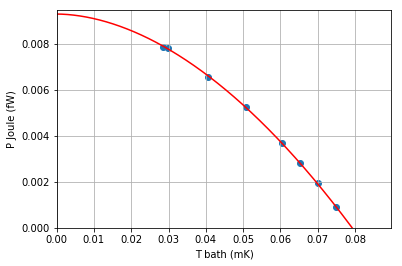

In [86]:
st.analyse_IV(0.00239)